<font size="5"> **Mixed layer depth in the Southern Ocean** </font>  
  
This script produces plots of Mixed Layer Depth (MLD) around the Southern Ocean using outputs from ACCESS-OM2-01. It also compares model outputs to observations.
  
**Requirements:** It is suggested you use the `conda/analysis3-20.07` (or later). This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a code cell.

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe
import rioxarray
from scipy.io import loadmat

The following modules are used in plotting maps and time series.

In [2]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.cm as mcm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm           
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses outputs for the second cycle, v140 run of ACCESS-OM2-01, which includes wind forcing. A list of ACCESS-OM2-01 experiments can be accessed using `cc.querying.get_experiments(session)`. A detailed list of experiments can be obtained by adding the following argument: `all = True`.

## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [9]:
varDict =  {'var_id': 'mld',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'mixed layer depth',
             'short_name': 'MLD',
             'unit': 'm',
             'CICE_data': False,
             'base_data': r'/g/data/v45/la6889/Calculations/MLD/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/MLD/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/MLD/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/Calculations/MLD/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/MLD/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/MLD/ClippedMEASOregions/',
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/MLD/DecadalSeasonal/Means',
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/MLD/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/MLD/TimeSeries/',
             'res': '0.1°'}

## Accessing ACCESS-OM2 outputs and saving results to disk

In [14]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = False)
    #Removing time bounds attribute causing issues when saving data
    del SO.attrs['time_bounds']
    
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'MixedLayerDepth_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

### Loading longitude corrected sea ice concentration data from disk

In [10]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], '*.nc')))

#Empty list to store files
SO = []

#Loading single files
for i, file in enumerate(filelist):
    stime = str(varDict['decades'][i]-1) + '-12'
    etime = str(varDict['decades'][i]+9) + '-11'
    x = xr.open_dataarray(file).sel(time = slice(stime, etime))
    SO.append(x)

#Concantenating all files into a single data array
SO = xr.concat(SO, dim = 'time')

## Loading MEASO regions to overlay them on plots

<AxesSubplot:>

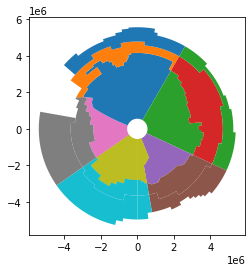

In [5]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Add a column with the long name for each MEASO area
MEASO = MEASO.assign(long_name = (MEASO.sector + ' ' + MEASO.zone).to_list())

#Checking results
MEASO.plot(column = 'long_name')

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [ ]:
clim_overall = zsf.climCalc(SO, [1979, 2008], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])
clim_seasonal = zsf.climCalc(SO, [1979, 2008], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])
clim_monthly = zsf.climCalc(SO, [1979, 2008], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

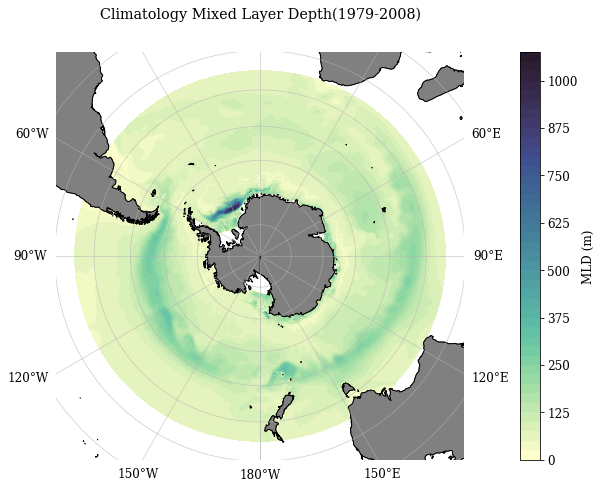

In [121]:
filepath = glob(os.path.join(varDict['climatologies'], '*overall*.nc'))

clim_overall = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Setting color palette levels
maxv = np.ceil(float(clim_overall.max().values))+25
levels = np.arange(0, maxv, 25)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.deep, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = (varDict['short_name'] + ' (' + varDict['unit'] + ')'), pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

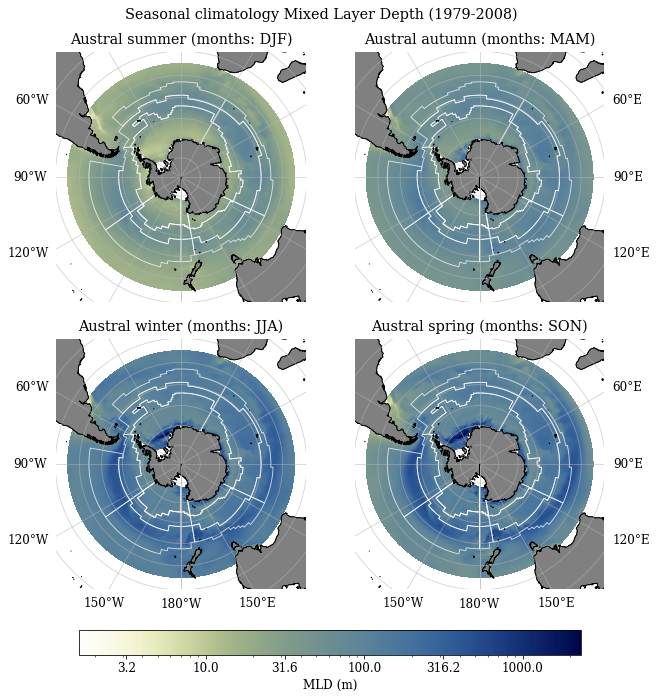

In [8]:
#Get full path for seasonal climatology
filepath = glob(os.path.join(varDict['climatologies'], '*seasonal*.nc'))

#Load data
clim_seasonal = xr.open_dataarray(filepath[0])

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Create log scale for colorbar
log_norm = mcolors.LogNorm(vmin = clim_seasonal.min().values, 
                           vmax = clim_seasonal.max().values)
#Create a list for ticks
cbar_ticks = [10**i for i in np.arange(np.floor(np.log10(clim_seasonal.min().values)),
                                       np.ceil(np.log10(clim_seasonal.max().values)), 0.5)]

#Get a colormap from Scientific Colour Maps
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#Ensure labels created using LaTeX appear as regular text
plt.rcParams.update({'mathtext.default': 'regular'})

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

#Initialise list to save figure axes
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
        
    #Extract information for each season and start plotting
    p1 = clim_seasonal.sel(season = season).\
    plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                    #Use colormap created at the beginning of the block and apply log-transformed colormap
                    cmap = cmap_r, norm = log_norm,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    #Overlay MEASO regions
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'white',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set shared colourbar for all plots
cb = fig.colorbar(p1, ax = [ax[a] for a in ax], orientation = 'horizontal', 
                  shrink = 0.9, pad = 0.06, 
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')
#Show colorbar ticks
cb.set_ticks(cbar_ticks)
cb.set_ticklabels(np.round(cbar_ticks, 1))
    
fig.suptitle('Seasonal climatology ' + varDict['long_name'].title() + ' (1979-2008)',
             y = 0.93)

fn = 'SeasonalClimatology_' + varDict['short_name'] + '_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in sea ice seasonality

## Defining seasons

In [7]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

## Separating data into seasons

In [11]:
climdata = SO.sel(time = slice('1978-12', '2008-11'))

seasons_SO = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SO[season] = xr.concat(y, dim = 'time')

## Calculating linear trends for model data

In [11]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_MLD_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SO[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SO[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [13]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

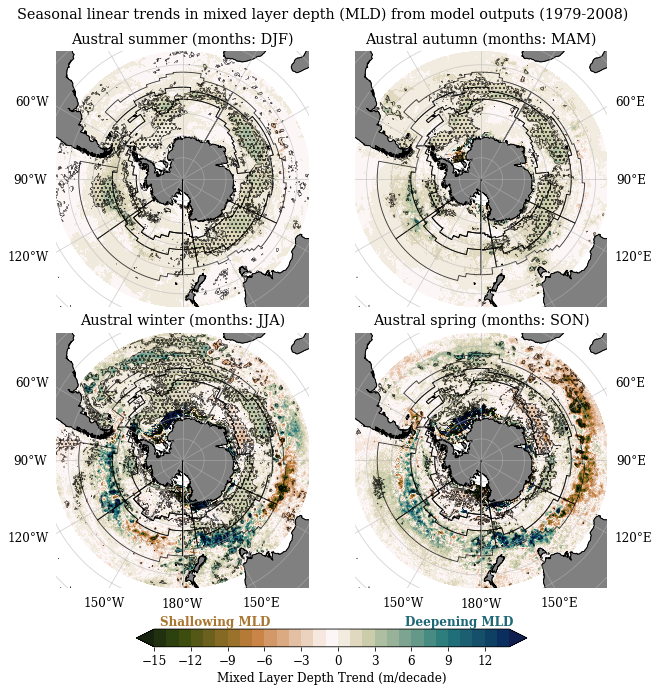

In [22]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set labels for plotting
# levels = np.arange(-220.5, 242.6, 1)
levels = np.arange(-15, 15)
#Set diverging color bar
# divnorm = mcolors.TwoSlopeNorm(vmin = -220.5, vcenter = 0, vmax = 242.5)

#Set NA values to appear as white
cmap = plt.get_cmap(cm.cm.tarn)
cmap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    #Multiplying by 10 to get change in meters per decade
    data = LM_results[season].coefficients*10
    #Plotting
    p1 = data.where(data != 0, np.nan).plot\
    .pcolormesh(ax = ax[season], cmap = cmap,
               transform = ccrs.PlateCarree(), levels = levels,
               # norm = divnorm, 
               add_colorbar = False)
    
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results[season].p_values <= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black', transform = ccrs.PlateCarree(),
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              transform = ccrs.PlateCarree(), 
                                              add_colorbar = False)
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 0.9, ax = ax[season], edgecolor = 'black',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Mixed Layer Depth Trend (m/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(cm.cm.tarn)
cb.ax.text(5.5, 20.5, 'Deepening MLD', color = cmap(0.85), fontweight = 'bold')
cb.ax.text(-14.5, 20.5, 'Shallowing MLD', color = cmap(0.25), fontweight = 'bold')

fig.suptitle('Seasonal linear trends in mixed layer depth (MLD) from model outputs (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_MLD_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Loading observations for comparison
Observations were obtained from [Sallee et al 2021](https://doi.org/10.1038/s41586-021-03303-x), which include data for mixed layer depth between 1970 and 2018. Dataset was downloaded from their [Zenodo repository](https://zenodo.org/record/4073174#.YaRsq9BBw2z). Below is an explanation of the steps taking in processing this data for comparison with ACCESS-OM2-01 outputs.

In [6]:
#Loading the MATLAB data structure to the notebook
obs = loadmat(r'/g/data/v45/la6889/MLD_Stratification_1970_2018.mat')

## Checking all variables included in this data structure
Note that the data structure is loaded as a dictionary in Python. All variables of interest are included under the `out` key.

In [7]:
obs['out'].dtype

dtype([('ML_NUM_PROFS', 'O'), ('ML_PRESSURE_WEIGHTED_MEAN', 'O'), ('ML_PRESSURE_WEIGHTED_STD', 'O'), ('ML_PRESSURE_WEIGHTED_Trend', 'O'), ('ML_PRESSURE_WEIGHTED_SE', 'O'), ('ML_N215_WEIGHTED_MEAN', 'O'), ('ML_N215_WEIGHTED_STD', 'O'), ('ML_N215_WEIGHTED_TREND', 'O'), ('ML_N215_WEIGHTED_SE', 'O'), ('ML_NS200_WEIGHTED_MEAN', 'O'), ('ML_NS200_WEIGHTED_STD', 'O'), ('ML_NS200_WEIGHTED_TREND', 'O'), ('ML_NS200_WEIGHTED_SE', 'O'), ('ML_NT200_WEIGHTED_MEAN', 'O'), ('ML_NT200_WEIGHTED_STD', 'O'), ('ML_NT200_WEIGHTED_TREND', 'O'), ('ML_NT200_WEIGHTED_SE', 'O'), ('ML_NS15_WEIGHTED_MEAN', 'O'), ('ML_NS15_WEIGHTED_STD', 'O'), ('ML_NS15_WEIGHTED_TREND', 'O'), ('ML_NS15_WEIGHTED_SE', 'O'), ('ML_NT15_WEIGHTED_MEAN', 'O'), ('ML_NT15_WEIGHTED_STD', 'O'), ('ML_NT15_WEIGHTED_TREND', 'O'), ('ML_NT15_WEIGHTED_SE', 'O'), ('ML_TEMPERATURE_WEIGHTED_MEAN', 'O'), ('ML_TEMPERATURE_WEIGHTED_STD', 'O'), ('ML_TEMPERATURE_WEIGHTED_Trend', 'O'), ('ML_TEMPERATURE_WEIGHTED_SE', 'O'), ('LONGITUDE', 'O'), ('LATITUDE', 'O'

## Extracting latitude and longitude values
The data structure is nested inside two data frames.

In [7]:
lon = obs['out']['LONGITUDE'][0][0][:,0]
lat = obs['out']['LATITUDE'][0][0][:,0]

## Extracting monthly climatological means
This information is included under the `ML_PRESSURE_WEIGHTED_MEAN` variable and as with the coordinates, it is nested within two data frames. A data array is constructed using these values.

In [9]:
clim_means_obs = xr.DataArray(data = obs['out']['ML_PRESSURE_WEIGHTED_MEAN'][0][0], 
                              dims = ['time', 'lat', 'lon'],
                              coords = {'lat': lat, 'lon': lon, 
                                        #Each time step represents a month
                                        'time': range(1, 13)})
#Check resulting data array
clim_means_obs

<xarray.DataArray (time: 12, lat: 337, lon: 720)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [42.76809311, 42.85644531, 42.46590424, ..., 42.4318161 ,
         42.79157639, 42.57035446],
        [41.58329391, 41.75262451, 42.0749855 , ..., 41.52392578,
         41.82788467, 41.82413101],
        [39.58028412, 39.85407639, 39.37922668, ..., 39.84390259,
         39.04476547, 39.25085068]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [28.11501884, 32.53411484, 32.86395645, ..., 31.43890762,
         31.81669617, 32.07110214],
        [25.88079643, 26.13951492, 30.67384529, ..., 25.77603722,
         27.66556931, 27.97156715],
        [27.29957962, 27.47820854, 28.14389801, ..., 28.02156639,
         28.46961975, 26.59900093]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [37.3657341 , 37.25245285, 38.0163765 , ..., 37.47829437,
         39.17306519, 40.98516846],
        [35.38875198, 35.59017944, 35.63025284, ..., 37.06513977,
         35.92289734, 36.00498581],
        [34.18740845, 33.01956177, 33.45966339, ..., 33.95323181,
         34.36613464, 34.15859222]]])
Coordinates:
  * lat      (lat) float64 -78.4 -77.9 -77.4 -76.9 -76.4 ... 88.1 88.6 89.1 89.6
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [11]:
#Checking min and max values in climatological means
clim_means_obs.min(), clim_means_obs.max()

(<xarray.DataArray ()>
 array(-61033.7734375),
 <xarray.DataArray ()>
 array(37327.14453125))

## Calculating winter and summer climatological means to recreate plots in Sallee et al.

In [12]:
winter_south = clim_means_obs.sel(time = slice(8, 10)).mean('time')
summer_south = clim_means_obs.sel(time = slice(1, 3)).mean('time')

## Plotting results
Figures 2E and 2F are in fact composites, which show winter/summer in both hemispheres. Limits of colour bars set to the match figures in Sallee et al.

### Winter composite

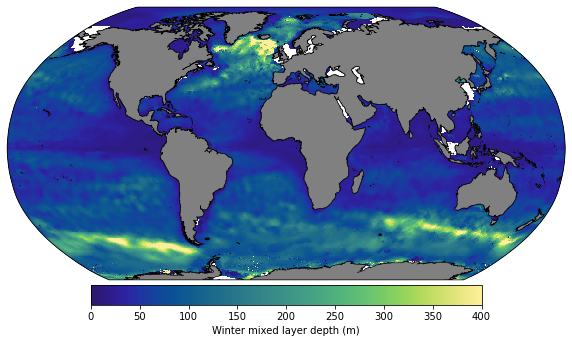

In [20]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres
north = summer_south.sel(lat = slice(0.1, 90))
south = winter_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(vmin = 0, vmax = 400, transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(vmin = 0, vmax = 400, transform = ccrs.PlateCarree(), ax = ax, 
                      cmap = cm.cm.haline, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add colorbar at the bottom of the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01, 
                  label  = 'Winter mixed layer depth (m)')

### Summer composite

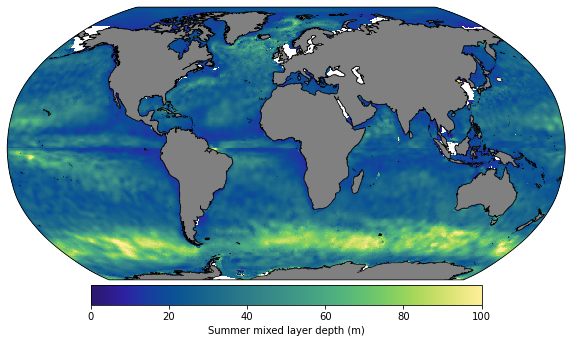

In [35]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north = winter_south.sel(lat = slice(0.1, 90))
south = summer_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(vmin = 0, vmax = 100, transform = ccrs.PlateCarree(), ax = ax,
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(vmin = 0, vmax = 100, transform = ccrs.PlateCarree(), ax = ax, 
                      cmap = cm.cm.haline, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add colorbar at the bottom of the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Summer mixed layer depth (m)')

## Finding location of negative values
At least one negative value was located when min and max values were calculated for the data array. Finding their location in this section.

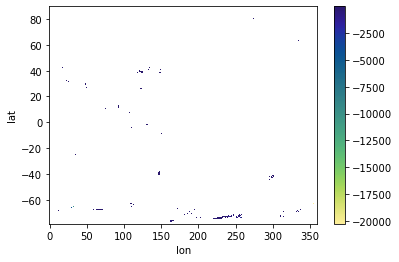

In [17]:
#Negative values austral winter
winter_south.where(winter_south < 0, np.nan).plot(cmap = cm.cm.haline_r)

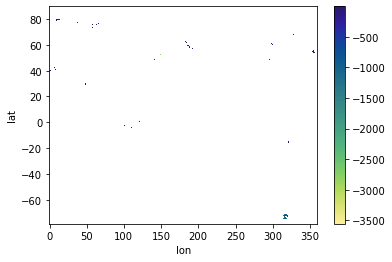

In [18]:
#Negative values austral summer
summer_south.where(summer_south < 0, np.nan).plot(cmap = cm.cm.haline_r)

## Location of extreme values
Extreme values are defined here as any values above the maximum limit shown in the colour bars. Composite images are used here.

### Winter composite

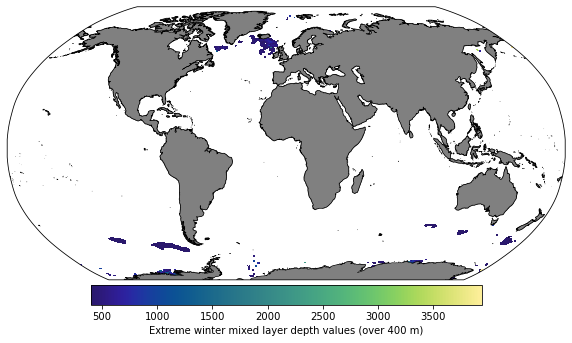

In [38]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres, but only show 
#values above the colourbar limit for the season (400 m)
north = summer_south.where(summer_south > 400, np.nan).sel(lat = slice(0.1, 90))
south = winter_south.where(winter_south > 400, np.nan).sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, cmap = cm.cm.haline,
                      add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01,
                 label  = 'Extreme winter mixed layer depth values (over 400 m)')

### Summer composite

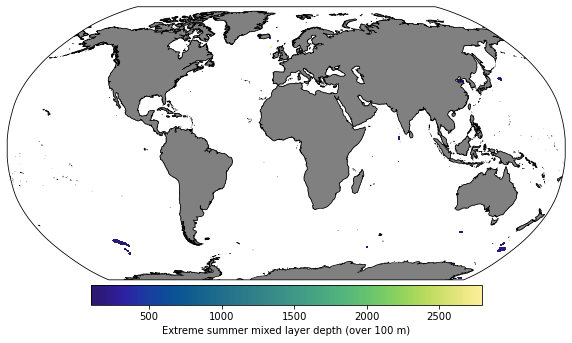

In [39]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres, but only show 
#values above the colourbar limit for the season (400 m)
north = winter_south.where(winter_south > 100, np.nan).sel(lat = slice(0.1, 90))
south = summer_south.where(summer_south > 100, np.nan).sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, 
                           add_colorbar = False, cmap = cm.cm.haline)
south.plot.pcolormesh(transform = ccrs.PlateCarree(), ax = ax, cmap = cm.cm.haline, 
                      add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Extreme summer mixed layer depth (over 100 m)')

## Seasonal linear trends
In this section, we replicate Figure 3C from Sallee et al. For this we need to variables: `ML_PRESSURE_WEIGHTED_Trend`, which contains the monthly trends, and `ML_PRESSURE_WEIGHTED_SE`, which contains the standard errors per month. Trends are considered to be significant if they are above the standard error.

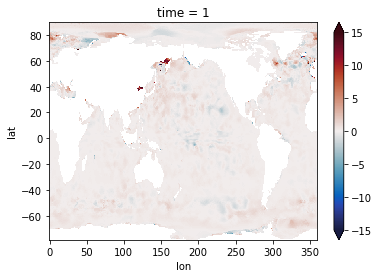

In [8]:
month_trend_obs = xr.DataArray(data = obs['out']['ML_PRESSURE_WEIGHTED_Trend'][0][0],
                               dims = ['time', 'lat', 'lon'],
                               coords = {'lat': lat, 'lon': lon, 
                                         #Monthly data
                                         'time': range(1, 13)})
month_trend_obs[0].plot(vmin = -15, vmax = 15, cmap = cm.cm.balance)

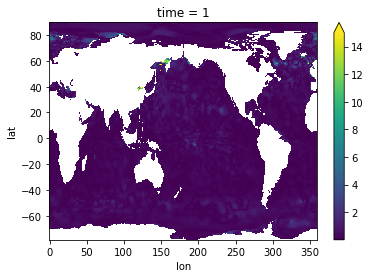

In [9]:
abs_trends = np.fabs(month_trend_obs)
abs_trends[0].plot(vmax = 15)

In [10]:
month_se_obs = xr.DataArray(data = obs['out']['ML_PRESSURE_WEIGHTED_SE'][0][0],
                            dims = ['time', 'lat', 'lon'],
                            coords = {'lat': lat, 'lon': lon, 
                                      #Montly data
                                      'time': range(1, 13)})
month_se_obs.min(), month_se_obs.max()

(<xarray.DataArray ()>
 array(0.00419464),
 <xarray.DataArray ()>
 array(10327.43066406))

### Masking out non-significant trends 

In [129]:
masked_trend_obs = xr.where(abs_trends > month_se_obs, month_trend_obs, np.nan)

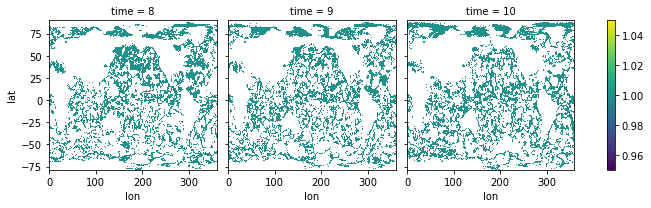

In [34]:
masked_month_obs = xr.where(abs_trends < month_se_obs, 1, np.nan)
masked_month_obs.sel(time = slice(8, 10)).plot(col = 'time')

In [36]:
masked_month_winter = masked_month_obs.sel(time = slice(8, 10)).mean('time')
masked_month_summer = masked_month_obs.sel(time = slice(8, 10)).mean('time')

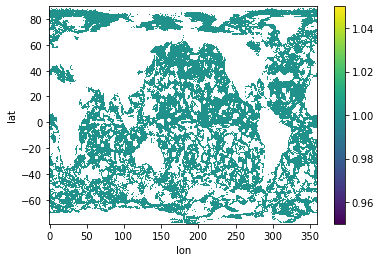

In [41]:
masked_month_winter.plot()

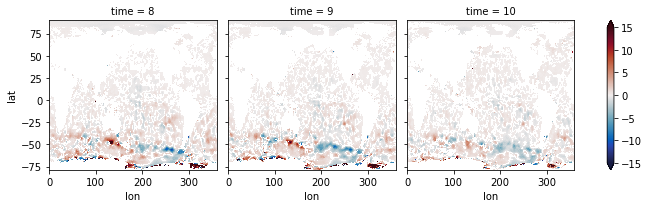

In [146]:
masked_trend_obs.sel(time = slice(8, 10)).plot(vmin = -15, vmax = 15, col = 'time', cmap = cm.cm.balance)

## Calculating mean seasonal trends

In [147]:
winter_trend_south = masked_trend_obs.sel(time = slice(8, 10)).mean('time')
summer_trend_south = masked_trend_obs.sel(time = slice(1, 3)).mean('time')

## Plotting mean seasonal trends

### Winter composite

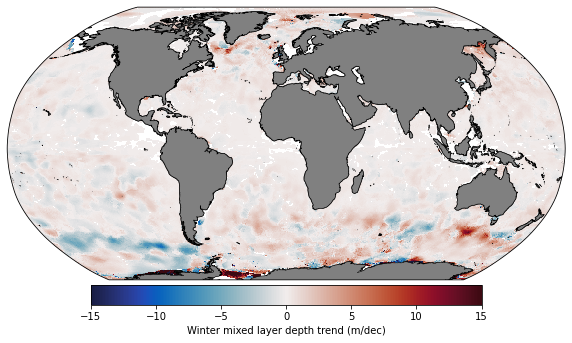

In [148]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for winter in the northern and southern hemispheres
north_trend = summer_trend_south.sel(lat = slice(0.1, 90))
south_trend = winter_trend_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
south_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, pad = 0.01,
                 label  = 'Winter mixed layer depth trend (m/yr?)')

### Summer composite

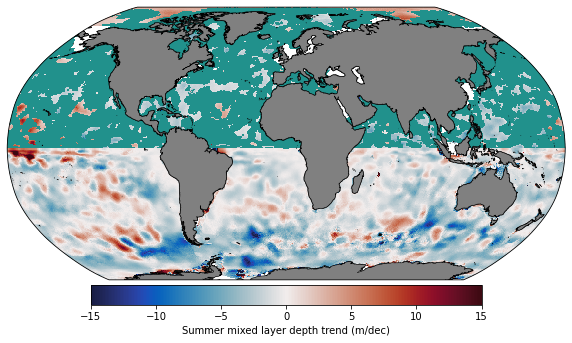

In [40]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and summer hemispheres
north_trend = month_trend_obs.sel(time = slice(8, 10)).mean('time').sel(lat = slice(0.1, 90))
north_mask = masked_month_winter.where(masked_month_winter == 1).sel(lat = slice(0.1, 90))
south_trend = month_trend_obs.sel(time = slice(1, 3)).mean('time').sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = (north_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
north_mask.plot(transform = ccrs.PlateCarree(), ax = ax, add_colorbar = False)
(south_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Summer mixed layer depth trend (m/dec)')

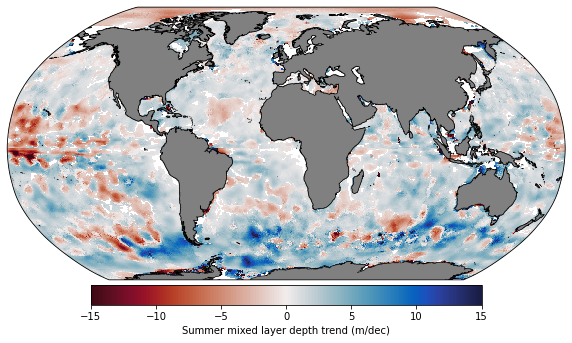

In [149]:
#Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and summer hemispheres
north_trend = winter_trend_south.sel(lat = slice(0.1, 90))
south_trend = summer_trend_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = (north_trend*10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance_r)
(south_trend*10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance_r, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',
                 label  = 'Summer mixed layer depth trend (m/dec)')

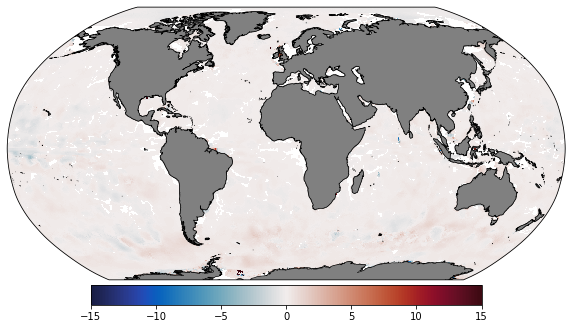

In [152]:
##Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north_trend = winter_trend_south.sel(lat = slice(0.1, 90))
south_trend = summer_trend_south.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = north_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
south_trend.plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',)
                 # label  = 'Summer mixed layer depth trend (m/dec)')

In [11]:
winter_se_south = month_se_obs.sel(time = slice(8, 10)).mean('time')
summer_se_south = month_se_obs.sel(time = slice(1, 3)).mean('time')
winter_m_south = month_trend_obs.sel(time = slice(8, 10)).mean('time')
summer_m_south = month_trend_obs.sel(time = slice(1, 3)).mean('time')
winter_abs_south = np.fabs(winter_m_south)
summer_abs_south = np.fabs(summer_m_south)

In [12]:
# masked_winter = xr.where(winter_abs_south > winter_se_south, winter_m_south, np.nan)
# masked_summer = xr.where(summer_abs_south > summer_se_south, summer_m_south, np.nan)

In [15]:
mask_winter = xr.where(winter_abs_south < winter_se_south, 1, np.nan)
mask_summer = xr.where(summer_abs_south < summer_se_south, 1, np.nan)

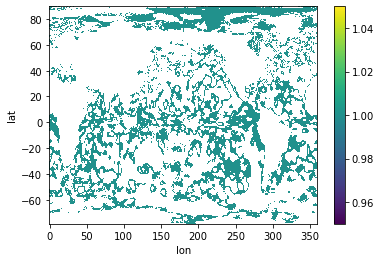

In [27]:
mask_summer.plot(vmin = 1)

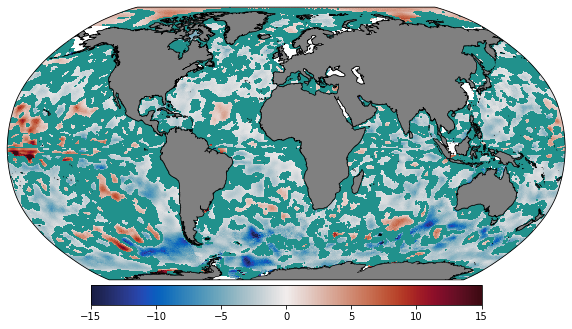

In [33]:
##Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north_trend = winter_m_south.sel(lat = slice(0.1, 90))
north_mask = mask_winter.where(mask_winter == 1).sel(lat = slice(0.1, 90))
south_trend = summer_m_south.sel(lat = slice(-90, 0))
south_mask = mask_summer.where(mask_summer == 1).sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = (north_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
north_mask.plot(transform = ccrs.PlateCarree(), ax = ax, add_colorbar = False)
(south_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)
south_mask.plot(transform = ccrs.PlateCarree(), ax = ax, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',)
                 # label  = 'Summer mixed layer depth trend (m/dec)')

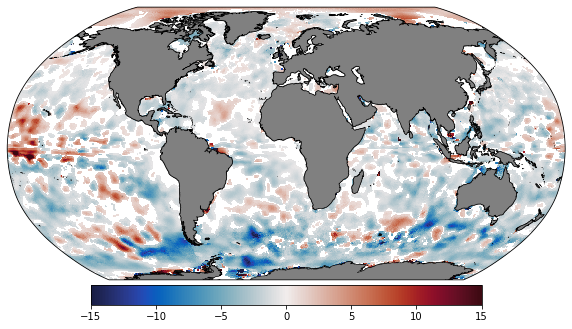

In [13]:
##Start a figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

#Extract values for summer in the northern and southern hemispheres
north_trend = masked_winter.sel(lat = slice(0.1, 90))
south_trend = masked_summer.sel(lat = slice(-90, 0))

#Plot both hemispheres in the same figure
p1 = (north_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                                 ax = ax, add_colorbar = False, cmap = cm.cm.balance)
(south_trend*-10).plot.pcolormesh(vmin = -15, vmax = 15, transform = ccrs.PlateCarree(), 
                            ax = ax, cmap = cm.cm.balance, add_colorbar = False)

#Overlay land areas
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)
ax.coastlines()
ax.add_feature(land_50m)

#Add a colorbar to the figure
cb = fig.colorbar(p1, ax = ax, shrink = 0.7, pad = 0.01, orientation = 'horizontal',)
                 # label  = 'Summer mixed layer depth trend (m/dec)')

# Comparisons observations vs model

## Separating model data into seasons

In [26]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

In [30]:
climdata = SO.sel(time = slice('1970-01', '2018-12'))

seasons_SO = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SO[season] = xr.concat(y, dim = 'time')

## Calculating linear trends for model data

In [31]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_MLD_{season}_1970-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SO[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SO[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SO[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO[season].yt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))